<a href="https://colab.research.google.com/github/Saketh2611/signature-verification-dcgan/blob/main/DCGAN_for_Signature_Synthesis_%2B_Verification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading GPU

In [1]:
!nvidia-smi


Sat Jun 21 05:37:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   59C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip install -U gdown


In [2]:
import gdown

file_id = "1CAjtavJerVnrObpj10GHT4P-muqILVL7"
url = f"https://drive.google.com/uc?id={file_id}"
output = "signatures.zip"
gdown.download(url, output, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1CAjtavJerVnrObpj10GHT4P-muqILVL7
From (redirected): https://drive.google.com/uc?id=1CAjtavJerVnrObpj10GHT4P-muqILVL7&confirm=t&uuid=95414b4f-6eae-41b8-b050-a5725265cc68
To: /content/signatures.zip
100%|██████████| 254M/254M [00:06<00:00, 40.0MB/s]


'signatures.zip'

In [3]:
import zipfile

with zipfile.ZipFile("signatures.zip", 'r') as zip_ref:
    zip_ref.extractall("signatures")  # creates a folder named 'signatures'


In [4]:
import os

# Traverse the extracted directory and print all folder paths
for root, dirs, files in os.walk("signatures"):
    print(f"📂 Folder: {root}")
    if dirs:
        print("   Subfolders:", dirs)
    if files:
        print("   Files:", files[:5])


📂 Folder: signatures
   Subfolders: ['signatures']
📂 Folder: signatures/signatures
   Subfolders: ['full_forg', 'full_org']
   Files: ['Readme.txt']
📂 Folder: signatures/signatures/full_forg
   Files: ['forgeries_2_6.png', 'forgeries_55_17.png', 'forgeries_10_7.png', 'forgeries_38_5.png', 'forgeries_18_6.png']
📂 Folder: signatures/signatures/full_org
   Files: ['original_53_17.png', 'original_19_11.png', 'original_50_13.png', 'original_12_13.png', 'original_27_21.png']


In [5]:
base_dir = "signatures/signatures"
print("Original:", os.listdir(f"{base_dir}/full_org")[:5])
print("Forged:", os.listdir(f"{base_dir}/full_forg")[:5])


Original: ['original_53_17.png', 'original_19_11.png', 'original_50_13.png', 'original_12_13.png', 'original_27_21.png']
Forged: ['forgeries_2_6.png', 'forgeries_55_17.png', 'forgeries_10_7.png', 'forgeries_38_5.png', 'forgeries_18_6.png']


# 📚 Importing Essential Libraries and
# ⚙️ Check and Set Device (GPU if available)

In [6]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
latent_dim = 100
hidden_dim = 64
image_size = 64
num_channels = 1
batch_size = 64
lr = 0.0002
beta1 = 0.5
num_epochs = 200

# Create output directory
os.makedirs("output", exist_ok=True)


In [7]:
import torch
print("CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    print("⚠️ Still running on CPU")


CUDA Available: True
Using GPU: Tesla T4


# 🧾 Custom Dataset Loader for Signature Images

In [8]:
class SignatureDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images = [os.path.join(data_dir, img) for img in os.listdir(data_dir) if img.endswith('.png')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)
        return image


# 🌀 Data Transformations and Loading Dataset

In [9]:
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# ✅ Path: update this if needed
data_path = "signatures/signatures/full_org"

dataset = SignatureDataset(data_dir=data_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


# 🎨 Generator Model: Generates Fake Signatures

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, hidden_dim * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(hidden_dim * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(hidden_dim * 8, hidden_dim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(hidden_dim * 4, hidden_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(hidden_dim * 2, hidden_dim, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(True),

            nn.ConvTranspose2d(hidden_dim, num_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

# 🕵️ Discriminator Model: Distinguishes Real vs Fake Signatures

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(num_channels, hidden_dim, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(hidden_dim, hidden_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(hidden_dim * 2, hidden_dim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(hidden_dim * 4, hidden_dim * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(hidden_dim * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).view(-1)

# 🔧 Weight Initialization

In [12]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# 🧬 Initialize Models

In [13]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)
generator.apply(weights_init)
discriminator.apply(weights_init)

criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))


# 🏁 Training Loop

In [ ]:
for epoch in range(num_epochs):
    for i, real_images in enumerate(dataloader):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)
        real_labels = torch.ones(batch_size).to(device)
        fake_labels = torch.zeros(batch_size).to(device)

        # Train Discriminator
        discriminator.zero_grad()
        outputs = discriminator(real_images)
        d_loss_real = criterion(outputs, real_labels)
        d_loss_real.backward()

        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_images = generator(noise)
        outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)
        d_loss_fake.backward()
        optimizer_d.step()

        # Train Generator
        generator.zero_grad()
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        optimizer_g.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch [{i}/{len(dataloader)}] "
                  f"D Loss: {(d_loss_real + d_loss_fake).item():.4f}, G Loss: {g_loss.item():.4f}")

    # Save sample outputs
    if epoch % 10 == 0:
        with torch.no_grad():
            fake_images = generator(torch.randn(16, latent_dim, 1, 1, device=device))
            torchvision.utils.save_image(fake_images, f"output/epoch_{epoch}.png", normalize=True)


In [15]:
torch.save(generator.state_dict(), "generator.pth")
torch.save(discriminator.state_dict(), "discriminator.pth")


# ✍️ Generate New Fake Signatures

In [16]:
def generate_signatures(num_samples, output_dir="output"):
    os.makedirs(output_dir, exist_ok=True)
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(num_samples, latent_dim, 1, 1, device=device)
        fake_images = generator(noise)
        for i in range(num_samples):
            torchvision.utils.save_image(fake_images[i], f"{output_dir}/signature_{i}.png", normalize=True)


# 🧪 Verify Whether a Signature is Real or Fake

In [17]:
def verify_signature(image_path):
    discriminator.eval()
    image = Image.open(image_path).convert('L')
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        score = discriminator(image).item()
    return "Real" if score > 0.5 else "Fake", score


In [18]:
# Generate 10 new synthetic signatures
generate_signatures(10)

# Test verification
test_path = 'signatures/signatures/full_forg/forgeries_1_10.png'  # update to any sample path
result, score = verify_signature(test_path)
print(f"Verification: {result} (Score: {score:.4f})")


Verification: Fake (Score: 0.0806)


# 📈 Plotting Real vs. Fake Signature Scores from the Discriminator

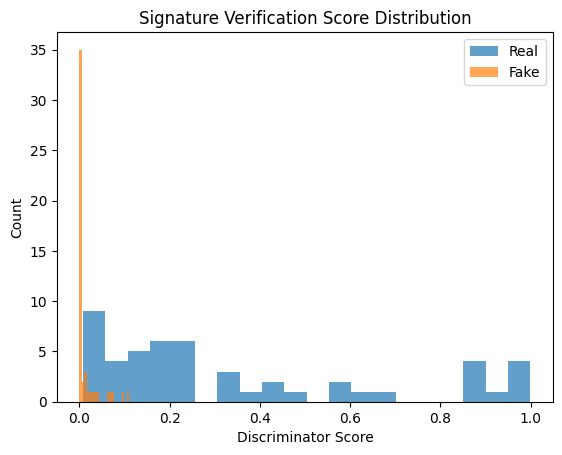

In [20]:
import matplotlib.pyplot as plt

real_scores = []
fake_scores = []

for img in os.listdir('signatures/signatures/full_org')[:50]:
    result, score = verify_signature(f'signatures/signatures/full_org/{img}')
    real_scores.append(score)

for img in os.listdir('signatures/signatures/full_forg')[:50]:
    result, score = verify_signature(f'signatures/signatures/full_forg/{img}')
    fake_scores.append(score)

plt.hist(real_scores, bins=20, alpha=0.7, label='Real')
plt.hist(fake_scores, bins=20, alpha=0.7, label='Fake')
plt.xlabel('Discriminator Score')
plt.ylabel('Count')
plt.legend()
plt.title('Signature Verification Score Distribution')
plt.show()


# Generate Signature Sample

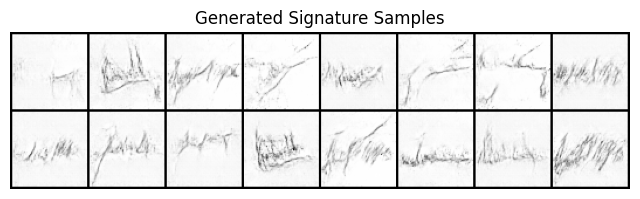

In [21]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Generate some signatures and display them
generator.eval()
with torch.no_grad():
    noise = torch.randn(16, latent_dim, 1, 1, device=device)
    fake_images = generator(noise)

# Plot 4x4 grid of generated signatures
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated Signature Samples")
plt.imshow(np.transpose(vutils.make_grid(fake_images.cpu(), padding=2, normalize=True), (1, 2, 0)))
plt.show()


In [22]:
# Real signature example
real_path = "signatures/signatures/full_org/original_11_3.png"  # change to a known real
result_real, score_real = verify_signature(real_path)
print(f"Real Signature: {result_real} (Score: {score_real:.4f})")

# Fake signature example
fake_path = "signatures/signatures/full_forg/forgeries_11_3.png"  # forged version of the same
result_fake, score_fake = verify_signature(fake_path)
print(f"Forged Signature: {result_fake} (Score: {score_fake:.4f})")


Real Signature: Real (Score: 0.7772)
Forged Signature: Fake (Score: 0.0021)


# 🧑‍🎓 Real Example

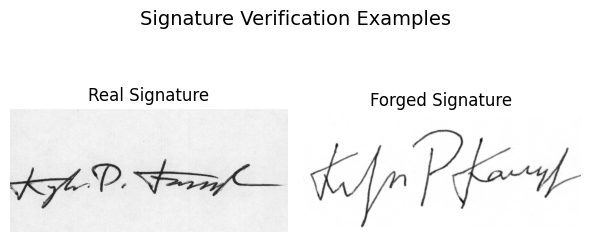

In [24]:
from PIL import Image
import matplotlib.pyplot as plt

real_img = Image.open("signatures/signatures/full_org/original_11_3.png").convert("L")
forg_img = Image.open("signatures/signatures/full_forg/forgeries_11_3.png").convert("L")

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.title("Real Signature")
plt.imshow(real_img, cmap='gray')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Forged Signature")
plt.imshow(forg_img, cmap='gray')
plt.axis("off")

plt.suptitle("Signature Verification Examples", fontsize=14)
plt.tight_layout()
plt.show()
